In [13]:
import torch
import sys

sys.path.append("..")
from RNN_Class import ElmanRNN_pytorch_module_v2  # or wherever the class lives
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ckpt_path = "../runs/ElmanRNN/random-init/random_n100_pytorch.pth.tar"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) read checkpoint (map to current device)
ckpt = torch.load(ckpt_path, map_location=device)

# 2) recover shape/config from checkpoint args
args = ckpt.get("args", None)
if args is None:
    # Fallback: infer from state_dict shapes
    sd = ckpt["state_dict"]
    H, N = sd["rnn.weight_hh_l0"].shape  # [H,H] and [H,N] are available
    input_dim = sd["rnn.weight_ih_l0"].shape[1]
    output_dim = sd["linear.weight"].shape[0]
else:
    N = int(args["n"])
    H = int(args["hidden_n"])
    input_dim = N
    output_dim = N

# 3) rebuild the model and load weights
model = ElmanRNN_pytorch_module_v2(input_dim, H, output_dim).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()  # inference mode

ElmanRNN_pytorch_module_v2(
  (rnn): RNN(100, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (act): Softmax(dim=2)
)

In [11]:
ckpt.keys()

dict_keys(['state_dict', 'y_hat', 'hidden', 'X_mini', 'Target_mini', 'loss', 'grad_norm', 'n_epochs', 'args', 'env', 'rng', 'snapshot_epochs'])

In [ ]:
ckpt["hidden"].shape

(100, 1, 99, 100)

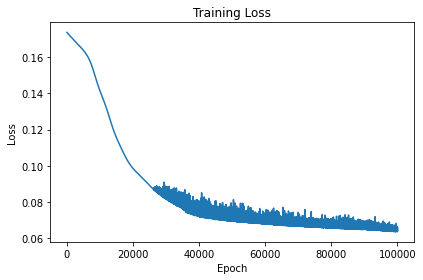

In [14]:
# --- Loss (saved per epoch) ---
loss = np.asarray(ckpt["loss"], dtype=float)

plt.figure()
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.tight_layout()
plt.show()  # or plt.savefig("loss.png"

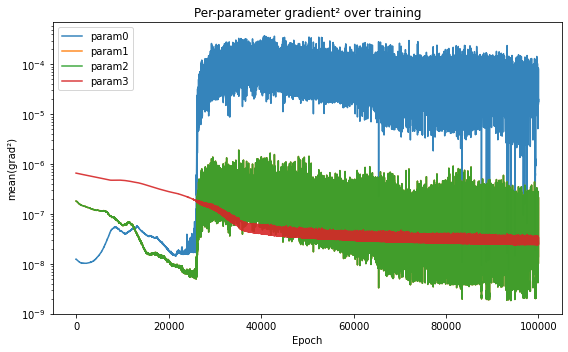

In [20]:
G = np.asarray(ckpt["grad_norm"], dtype=float)  # shape [epochs, n_params]

plt.figure(figsize=(8, 5))
for j in range(G.shape[1]):
    plt.semilogy(G[:, j], label=f"param{j}", alpha=0.9)
plt.xlabel("Epoch")
plt.ylabel("mean(grad²)")
plt.title("Per-parameter gradient² over training")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name}: {p.shape}")

rnn.weight_ih_l0: torch.Size([100, 100])
rnn.weight_hh_l0: torch.Size([100, 100])
rnn.bias_ih_l0: torch.Size([100])
rnn.bias_hh_l0: torch.Size([100])
linear.weight: torch.Size([100, 100])
linear.bias: torch.Size([100])
